# CESM2-LE Initial Condition Memory:  Zonal-mean TREFHT
 - Use Intake to access CESM2LE data on glade
 - Compute zonal mean annual TREFHT from CAM monthly output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
#import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmTREFHT.nc'
if (exists(pp_datafile)):
    print(pp_datafile+' already exists. You can skip Section 1. \n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_zmTREFHT.nc already exists. You can skip Section 1. 




## Create Dask Cluster

In [26]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(10) 

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

# Section 1

## Data Intake

In [3]:
# Point to the catalog file
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [4]:
# Find CAM assets
camdata = col.search(component='atm', variable=['TREFHT'], frequency='month_1', experiment=['historical','ssp370'])

In [5]:
camdata.df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,atm,cam.h0,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,TREFHT,1850-01,1859-12,185001-185912,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,atm,cam.h0,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,TREFHT,1860-01,1869-12,186001-186912,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,atm,cam.h0,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,TREFHT,1870-01,1879-12,187001-187912,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,atm,cam.h0,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,TREFHT,1880-01,1889-12,188001-188912,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,atm,cam.h0,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,TREFHT,1890-01,1899-12,189001-189912,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,atm,cam.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,TREFHT,2055-01,2064-12,205501-206412,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2
2596,atm,cam.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,TREFHT,2065-01,2074-12,206501-207412,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2
2597,atm,cam.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,TREFHT,2075-01,2084-12,207501-208412,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2
2598,atm,cam.h0,b.e21.BSSP370smbb.f09_g17.LE2-1301.020,r20i1301p1f2,TREFHT,2085-01,2094-12,208501-209412,Reference height temperature,K,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,smbb,1301.020,1301,CESM2_ssp370_r20i1301p1f2


In [8]:
## Use preprocessor to return annual mean
def preproc(ds):
    ds = calc.center_time(ds)
    ds_ann = ds.groupby('time.year').mean().rename({'year':'time'})
    return ds_ann

In [8]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = camdata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 13s, sys: 3.06 s, total: 1min 16s
Wall time: 1min 48s


In [9]:
dsets.keys()

dict_keys(['atm.historical.cam.h0.smbb.TREFHT', 'atm.ssp370.cam.h0.cmip6.TREFHT', 'atm.ssp370.cam.h0.smbb.TREFHT', 'atm.historical.cam.h0.cmip6.TREFHT'])

In [10]:
dsets['atm.historical.cam.h0.smbb.TREFHT'].TREFHT

,Array,Chunk
Bytes,1.70 GiB,216.00 kiB
Shape,"(50, 165, 192, 288)","(1, 1, 192, 288)"
Count,67700 Tasks,8250 Chunks
Type,float32,numpy.ndarray


## Data Processing

#### Zonal Mean computation:

In [11]:
%%time
smbbhist_zm = dsets['atm.historical.cam.h0.smbb.TREFHT'].TREFHT.mean('lon')
smbbssp_zm = dsets['atm.ssp370.cam.h0.smbb.TREFHT'].TREFHT.mean('lon')
cmiphist_zm = dsets['atm.historical.cam.h0.cmip6.TREFHT'].TREFHT.mean('lon')
cmipssp_zm = dsets['atm.ssp370.cam.h0.cmip6.TREFHT'].TREFHT.mean('lon')

CPU times: user 262 ms, sys: 8.04 ms, total: 270 ms
Wall time: 272 ms


In [12]:
## Create final Dataset:
work1 = xr.concat([cmiphist_zm,cmipssp_zm],dim='time')
work2 = xr.concat([smbbhist_zm,smbbssp_zm],dim='time')
cesm2le_zm = xr.concat([work1,work2],dim='member_id')
memid = cesm2le_zm.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le_zm.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le_zm.member_id})

ds = cesm2le_zm.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

Here is the actual computation:

In [13]:
%%time
ds = ds.load()

CPU times: user 43.3 s, sys: 543 ms, total: 43.8 s
Wall time: 45.7 s


In [14]:
pp_datafile

'/glade/scratch/yeager/cesm2_le/CESM2LE_zmTREFHT.nc'

In [15]:
%%time
ds.to_netcdf(pp_datafile)

CPU times: user 35 ms, sys: 5.99 ms, total: 41 ms
Wall time: 85.9 ms


<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [5]:
ds = xr.open_dataset(pp_datafile)
print('opening '+pp_datafile)

opening /glade/scratch/yeager/cesm2_le/CESM2LE_zmTREFHT.nc


In [6]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1101 : 001
1051 : 001
1141 : 001
1191 : 001
1121 : 001
1111 : 001
1161 : 001
1031 : 001
1131 : 001
1001 : 001
1171 : 001
1041 : 001
1011 : 001
1151 : 001
1181 : 001
1301 : 020
1061 : 001
1251 : 020
1231 : 020
1091 : 001
1071 : 001
1281 : 020
1021 : 001
1081 : 001


Apply low-pass filter:

In [7]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [8]:
ds['TREFHT'] = lpf_anndata(ds.TREFHT.transpose('time','member_id','lat'),period=15)

cutoff=  15.000000000000002  years


## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} + \sigma^{2}_{X,Cov(atm,ocn)}
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [9]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = ds.TREFHT.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id')

In [10]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.TREFHT.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2
# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi")

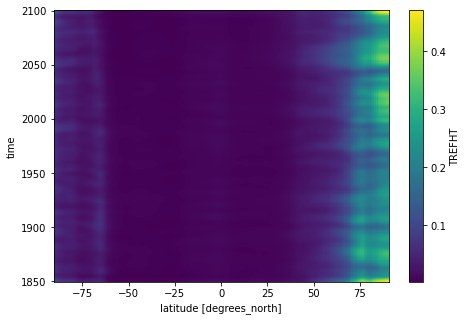

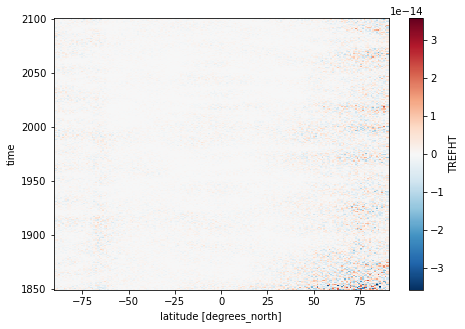

In [11]:
# Test for closure of variance budget:
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
#sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2_tot.plot(size=5)
sig2_resid.plot(size=5)

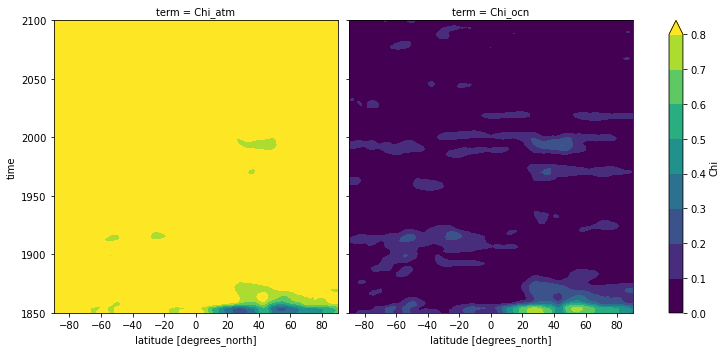

In [12]:
# Quick plot of Chi
chi = xr.concat([chi_atm,chi_ocn],dim=xr.DataArray(['Chi_atm','Chi_ocn'],dims='term',name='term'))
levs = np.arange(0,9)*0.1
chi.plot.contourf(col='term',size=5,levels=levs)

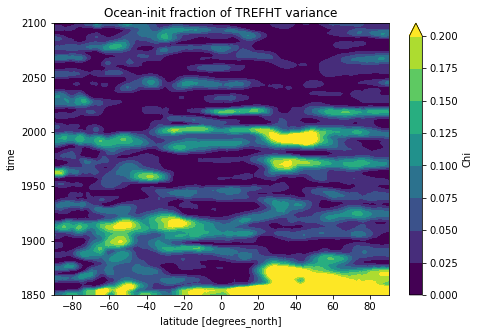

In [13]:
# Quick plot of Chi_ocn
levs = np.arange(0,9)*0.025
chi_ocn.plot.contourf(size=5,levels=levs)
plt.title('Ocean-init fraction of TREFHT variance');

## Compute bootstrapped significance

In [14]:
import xskillscore as xs

#### Simple test case to illustrate resample method from xskillscore:

In [15]:
# Generate test array whose data simply reflects model member
mems = np.arange(80)+1
da_test = xr.DataArray(np.broadcast_to(mems,(10,80)),dims=("time","member_id"),coords={"time":np.arange(10)+1900,"member_id":np.arange(80)})
da_test

<xarray.DataArray (time: 10, member_id: 80)>
array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
...
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]])
Coordinates:
  * time       (time) int64 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909
  * member_id  (member_id) int64 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79

Now, resample test array:

In [16]:
ens_size = 5     # sets ensemble size of sub-ensemble
iterations = 20  # sets number of sub-ensembles
da_allmem_r = xs.resample_iterations(da_test, iterations, 'member_id', dim_max=ens_size)
da_allmem_r

<xarray.DataArray (time: 10, member_id: 5, iteration: 20)>
array([[[21, 16,  5, 57, 69, 38,  5, 65, 44, 60, 40, 26, 10, 21, 67, 44,
         73, 76, 49, 71],
        [10,  3, 49, 10, 33, 27, 39, 29, 13,  4, 32, 40, 23, 18,  6, 55,
         55, 18,  9, 66],
        [ 2, 13, 64, 59, 68, 44, 14, 22,  8, 21, 46, 75, 25, 42, 69, 30,
         64, 44, 68, 65],
        [18, 70, 38,  2, 48, 58, 68, 33,  8, 42, 20, 20, 50, 56, 46,  1,
         45, 60, 76, 17],
        [78, 45,  7, 18, 28, 22, 12, 39,  2, 11, 18, 34, 52, 44,  1, 39,
          1, 40, 41, 33]],

       [[21, 16,  5, 57, 69, 38,  5, 65, 44, 60, 40, 26, 10, 21, 67, 44,
         73, 76, 49, 71],
        [10,  3, 49, 10, 33, 27, 39, 29, 13,  4, 32, 40, 23, 18,  6, 55,
         55, 18,  9, 66],
        [ 2, 13, 64, 59, 68, 44, 14, 22,  8, 21, 46, 75, 25, 42, 69, 30,
         64, 44, 68, 65],
        [18, 70, 38,  2, 48, 58, 68, 33,  8, 42, 20, 20, 50, 56, 46,  1,
         45, 60, 76, 17],
        [78, 45,  7, 18, 28, 22, 12, 39,  2, 11, 18, 34, 52, 44,  1, 39,
...
         73, 76, 49, 71],
        [10,  3, 49, 10, 33, 27, 39, 29, 13,  4, 32, 40, 23, 18,  6, 55,
         55, 18,  9, 66],
        [ 2, 13, 64, 59, 68, 44, 14, 22,  8, 21, 46, 75, 25, 42, 69, 30,
         64, 44, 68, 65],
        [18, 70, 38,  2, 48, 58, 68, 33,  8, 42, 20, 20, 50, 56, 46,  1,
         45, 60, 76, 17],
        [78, 45,  7, 18, 28, 22, 12, 39,  2, 11, 18, 34, 52, 44,  1, 39,
          1, 40, 41, 33]],

       [[21, 16,  5, 57, 69, 38,  5, 65, 44, 60, 40, 26, 10, 21, 67, 44,
         73, 76, 49, 71],
        [10,  3, 49, 10, 33, 27, 39, 29, 13,  4, 32, 40, 23, 18,  6, 55,
         55, 18,  9, 66],
        [ 2, 13, 64, 59, 68, 44, 14, 22,  8, 21, 46, 75, 25, 42, 69, 30,
         64, 44, 68, 65],
        [18, 70, 38,  2, 48, 58, 68, 33,  8, 42, 20, 20, 50, 56, 46,  1,
         45, 60, 76, 17],
        [78, 45,  7, 18, 28, 22, 12, 39,  2, 11, 18, 34, 52, 44,  1, 39,
          1, 40, 41, 33]]])
Coordinates:
  * time       (time) int64 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909
  * member_id  (member_id) int64 0 1 2 3 4
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19

In [17]:
da_allmem_r.values.min(),da_allmem_r.values.max()

(1, 78)

The xs.resample_iterations appears to work as expected. In the above example, a 5-member subensemble is drawn from the full ensemble pool (80-members) and occupies the "member_id" dimension. This resampling is repeated 20 times, to generate 20 different random 5-member subensembles. The "data" here reflects the original "member_id" coordinate, showing that the resampling is consistent across other dimensions (here, "time"). Now, test a second resampling:

In [18]:
ens_size = 4  # sets ensemble size of sub-ensemble
iterations = 10  # sets number of sub-ensembles
da_allmem_rr = xs.resample_iterations(da_allmem_r.rename({'iteration':'micro'}), iterations, 'micro', dim_max=ens_size)

This second resampling also works as expected. For each iteration, it returns a 4-group set of 5-member subensembles:

In [19]:
for i in range(5):
    print(da_allmem_rr.isel(time=1,iteration=i).values)

[[49 44 60 21]
 [ 9 13  4 18]
 [68  8 21 42]
 [76  8 42 56]
 [41  2 11 44]]
[[60  5  5 76]
 [ 4 39 39 18]
 [21 14 14 44]
 [42 68 68 60]
 [11 12 12 40]]
[[21 65 49  5]
 [18 29  9 39]
 [42 22 68 14]
 [56 33 76 68]
 [44 39 41 12]]
[[16 60  5 21]
 [ 3  4 49 18]
 [13 21 64 42]
 [70 42 38 56]
 [45 11  7 44]]
[[49 76 10 21]
 [ 9 18 23 10]
 [68 44 25  2]
 [76 60 50 18]
 [41 40 52 78]]


#### Use xskillscore to compute pvalues for Chi:

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [20]:
da_allmem

<xarray.DataArray 'TREFHT' (time: 251, member_id: 80, lat: 192)>
array([[[224.83208208, 224.96876874, 226.01907808, ..., 257.468216  ,
         257.47319069, 257.44160529],
        [225.29872898, 225.43442566, 226.44174569, ..., 256.67186898,
         256.65977186, 256.61980338],
        [224.71641161, 224.87702451, 225.93606438, ..., 254.90665532,
         254.84619529, 254.77955769],
        ...,
        [225.01959405, 225.16972307, 226.23914379, ..., 256.71264555,
         256.70845753, 256.67685508],
        [224.75506954, 224.92026504, 225.99414261, ..., 254.8006575 ,
         254.77804188, 254.73764136],
        [225.04618548, 225.21406548, 226.28161716, ..., 255.04503544,
         255.03526759, 254.99331888]],

       [[224.83686323, 224.97397467, 226.02441376, ..., 257.44941618,
         257.45371179, 257.42184264],
        [225.29887144, 225.43450362, 226.44199076, ..., 256.65593199,
         256.64420518, 256.60456288],
        [224.71948365, 224.87861514, 225.93685033, ..., 254.90790449,
         254.8470507 , 254.78040689],
...
        [232.95727023, 233.00917097, 233.87227465, ..., 267.68410709,
         267.65359612, 267.63332661],
        [232.67503939, 232.72628956, 233.58328386, ..., 268.01943106,
         267.997046  , 267.97678728],
        [232.58479082, 232.65876092, 233.54263841, ..., 267.45013439,
         267.42201763, 267.40636687]],

       [[232.68482837, 232.75096932, 233.63918778, ..., 267.40115291,
         267.39425764, 267.38386666],
        [233.61898583, 233.61615906, 234.43520481, ..., 268.59951916,
         268.59730298, 268.59507416],
        [232.98206841, 233.03607844, 233.88891062, ..., 267.98229044,
         267.96895118, 267.96926272],
        ...,
        [232.98094375, 233.03115795, 233.89207108, ..., 267.70737174,
         267.67796168, 267.65849191],
        [232.67650185, 232.72793005, 233.58538457, ..., 268.03703526,
         268.01343086, 267.99222876],
        [232.59714396, 232.67124289, 233.55531394, ..., 267.4677754 ,
         267.43931204, 267.42345448]]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * member_id  (member_id) object 'r10i1231p1f1' ... 'r20i1301p1f2'

In [21]:
iterations = 100
ens_size = 20
da_allmem_r = xs.resample_iterations(da_allmem, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

In [22]:
da_allmem_r

<xarray.DataArray 'TREFHT' (time: 251, member_id: 20, lat: 192, micro: 100)>
dask.array<xarray-<this-array>, shape=(251, 20, 192, 100), dtype=float64, chunksize=(251, 20, 192, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * member_id  (member_id) object 'r10i1231p1f1' ... 'r4i1301p1f1'
  * micro      (micro) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

In [23]:
da_allmem_r.member_id

<xarray.DataArray 'member_id' (member_id: 20)>
array(['r10i1231p1f1', 'r10i1251p1f1', 'r10i1281p1f1', 'r10i1301p1f1',
       'r1i1231p1f1', 'r1i1251p1f1', 'r1i1281p1f1', 'r1i1301p1f1',
       'r2i1231p1f1', 'r2i1251p1f1', 'r2i1281p1f1', 'r2i1301p1f1',
       'r3i1231p1f1', 'r3i1251p1f1', 'r3i1281p1f1', 'r3i1301p1f1',
       'r4i1231p1f1', 'r4i1251p1f1', 'r4i1281p1f1', 'r4i1301p1f1'],
      dtype=object)
Coordinates:
  * member_id  (member_id) object 'r10i1231p1f1' ... 'r4i1301p1f1'

Now, resample to generate 1000 different 4-micro combinations:

In [24]:
da_allmem_rr = xs.resample_iterations(da_allmem_r, 1000, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn:

In [25]:
%%time
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size

CPU times: user 10.4 s, sys: 2.02 s, total: 12.4 s
Wall time: 37.5 s


Compute significance as in Singh et al.:

In [26]:
%%time
ens_size = 20  # sets ensemble size of sub-ensemble
subens = 4  # sets number of sub-ensembles
iterations = 100
chilist = []
for i in range(iterations):
    da_allmem_r = xs.resample_iterations(da_allmem, subens, 'member_id', dim_max=ens_size).chunk()
    sig2_ocn_tmp = da_allmem_r.mean(dim='member_id').var('iteration')
    sig2_tot_tmp = da_allmem_r.var(['member_id','iteration'])
    tmp_chi = (sig2_ocn_tmp/sig2_tot_tmp).rename("Chi_ocn")
    chilist.append(tmp_chi)
chi_ocn_r = xr.concat(chilist,dim='iteration')
pval_singh = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
pval_singh = pval_singh.load()

CPU times: user 7.49 s, sys: 4.04 s, total: 11.5 s
Wall time: 12.7 s


/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'ls'
  primitive = ax.contour(x, y, z, **kwargs)


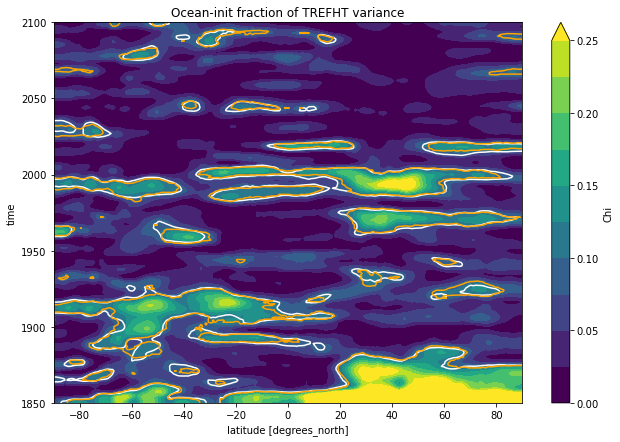

In [27]:
# Plot Chi_ocn with significance
levs = np.arange(0,11)*0.025
chi_ocn.plot.contourf(size=7,levels=levs)
pval.plot.contour(levels=[0.05],colors=['white'])
pval_singh.plot.contour(levels=[0.05],colors=['orange'],ls='-')
plt.title('Ocean-init fraction of TREFHT variance');

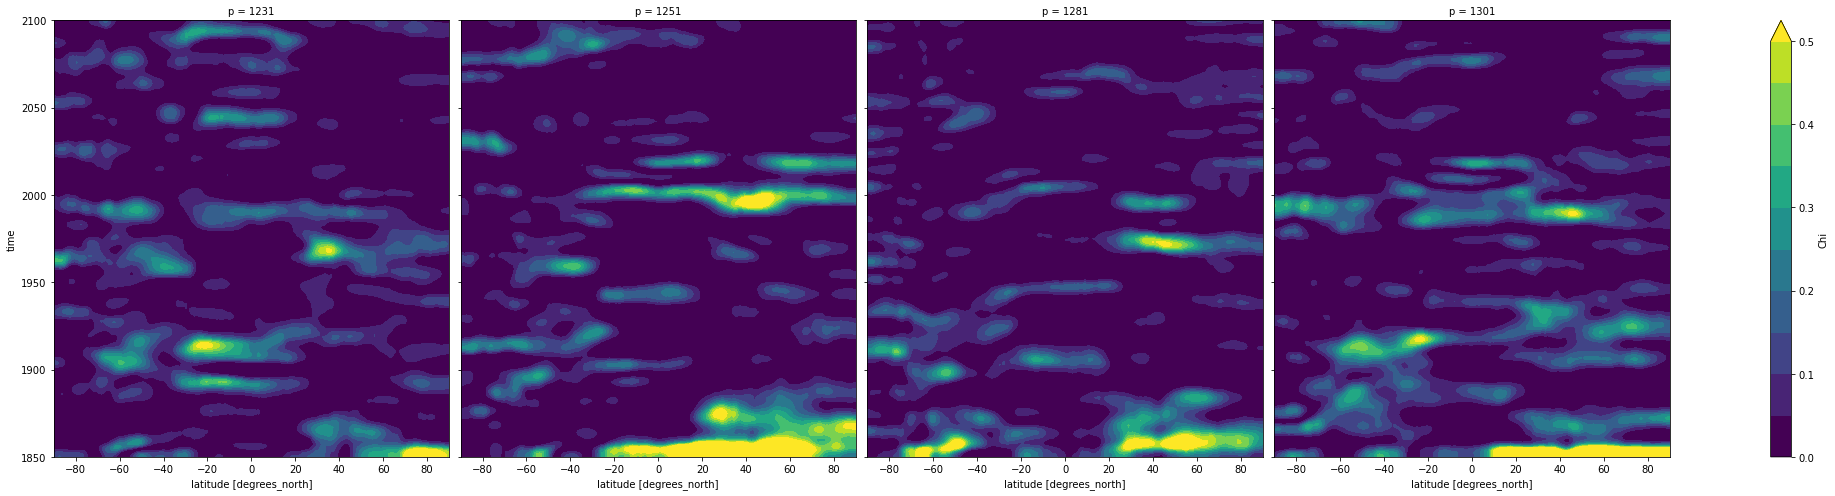

In [28]:
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',size=7,levels=levs)

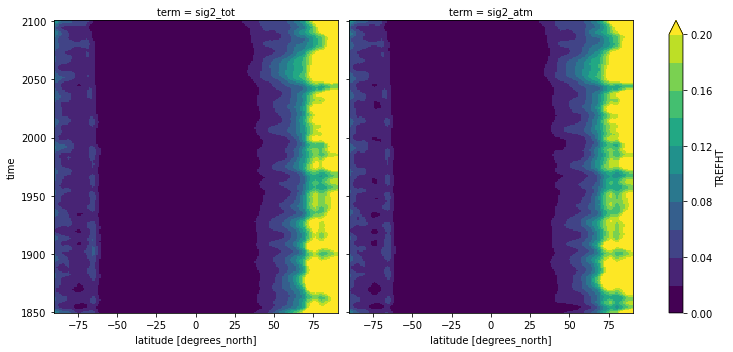

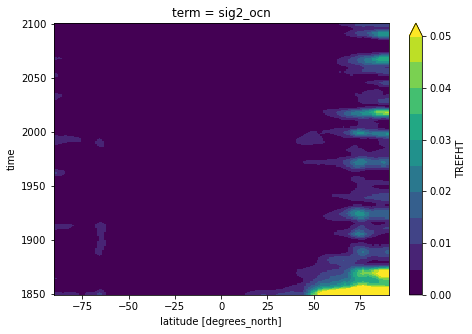

In [29]:
terms = xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn','sig2_residual'],dims='term',name='term')
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2 = xr.concat([sig2_tot,sig2_atm,sig2_ocn,sig2_resid],dim=terms)

levs = np.arange(0,11)*0.02
sig2.isel(term=[0,1]).plot(col='term',col_wrap=2,size=5,levels=levs)
levs = np.arange(0,11)*0.005
sig2.isel(term=2).plot(size=5,levels=levs)

In [31]:
np.arange(0,11)*0.01 - 0.05

array([-0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
        0.04,  0.05])

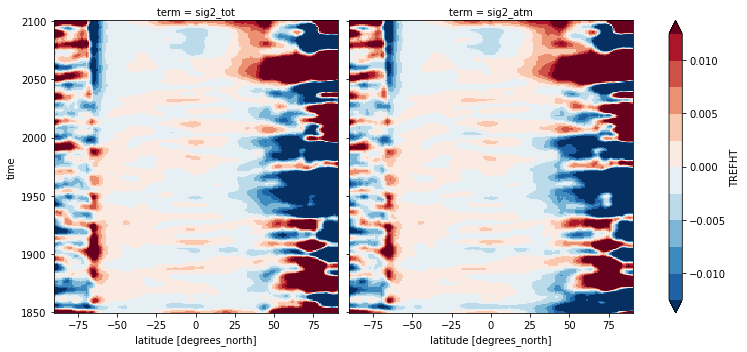

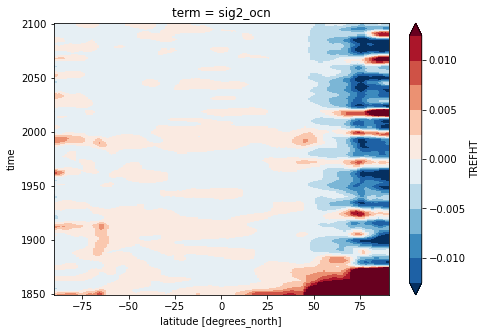

In [34]:
terms = xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn'],dims='term',name='term')
sig2_anom = xr.concat([sig2_tot,sig2_atm,sig2_ocn],dim=terms)
sig2_anom = sig2_anom - sig2_anom.mean('time')

levs = np.arange(0,11)*0.0025 - 0.0125
sig2_anom.isel(term=[0,1]).plot(col='term',col_wrap=2,size=5,levels=levs)
sig2_anom.isel(term=2).plot(size=5,levels=levs)

## Assess Sensitivity to bb versus smbb forcing over 1990-2020 period

### Guide to bb and smbb Micro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - cmip6 forcing:  members 001-010
  - smbb forcing:   members 011-020

In [42]:
iyear = ds.inityear.data
imem = [int(ds.memnum.data[i]) for i in range(ds.memnum.size)]
# cmip6 forcing
memind = np.nonzero(((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301')) & (np.less(imem,11)))
memind2 = np.nonzero(((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301')) & (np.greater(imem,10)))

In [43]:
ds.member_id[memind]

<xarray.DataArray 'member_id' (member_id: 40)>
array(['r10i1231p1f1', 'r10i1251p1f1', 'r10i1281p1f1', 'r10i1301p1f1',
       'r1i1231p1f1', 'r1i1251p1f1', 'r1i1281p1f1', 'r1i1301p1f1',
       'r2i1231p1f1', 'r2i1251p1f1', 'r2i1281p1f1', 'r2i1301p1f1',
       'r3i1231p1f1', 'r3i1251p1f1', 'r3i1281p1f1', 'r3i1301p1f1',
       'r4i1231p1f1', 'r4i1251p1f1', 'r4i1281p1f1', 'r4i1301p1f1',
       'r5i1231p1f1', 'r5i1251p1f1', 'r5i1281p1f1', 'r5i1301p1f1',
       'r6i1231p1f1', 'r6i1251p1f1', 'r6i1281p1f1', 'r6i1301p1f1',
       'r7i1231p1f1', 'r7i1251p1f1', 'r7i1281p1f1', 'r7i1301p1f1',
       'r8i1231p1f1', 'r8i1251p1f1', 'r8i1281p1f1', 'r8i1301p1f1',
       'r9i1231p1f1', 'r9i1251p1f1', 'r9i1281p1f1', 'r9i1301p1f1'],
      dtype=object)
Coordinates:
  * member_id  (member_id) object 'r10i1231p1f1' ... 'r9i1301p1f1'

In [31]:
ds.member_id[memind2]

<xarray.DataArray 'member_id' (member_id: 40)>
array(['r11i1231p1f2', 'r11i1251p1f2', 'r11i1281p1f2', 'r11i1301p1f2',
       'r12i1231p1f2', 'r12i1251p1f2', 'r12i1281p1f2', 'r12i1301p1f2',
       'r13i1231p1f2', 'r13i1251p1f2', 'r13i1281p1f2', 'r13i1301p1f2',
       'r14i1231p1f2', 'r14i1251p1f2', 'r14i1281p1f2', 'r14i1301p1f2',
       'r15i1231p1f2', 'r15i1251p1f2', 'r15i1281p1f2', 'r15i1301p1f2',
       'r16i1231p1f2', 'r16i1251p1f2', 'r16i1281p1f2', 'r16i1301p1f2',
       'r17i1231p1f2', 'r17i1251p1f2', 'r17i1281p1f2', 'r17i1301p1f2',
       'r18i1231p1f2', 'r18i1251p1f2', 'r18i1281p1f2', 'r18i1301p1f2',
       'r19i1231p1f2', 'r19i1251p1f2', 'r19i1281p1f2', 'r19i1301p1f2',
       'r20i1231p1f2', 'r20i1251p1f2', 'r20i1281p1f2', 'r20i1301p1f2'],
      dtype=object)
Coordinates:
  * member_id  (member_id) object 'r11i1231p1f2' ... 'r20i1301p1f2'

In [33]:
iyear = ds.inityear.data
imem = [int(ds.memnum.data[i]) for i in range(ds.memnum.size)]
# cmip6 forcing
memind = np.nonzero(((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301')) & (np.less(imem,11)))
ds_allmem_bb = ds.isel(member_id=memind[0])
sig2_tot_bb = ds_allmem_bb.TREFHT.var(dim='member_id')
allmean_bb = ds_allmem_bb.TREFHT.mean(dim='member_id')
# smbb forcing
memind = np.nonzero(((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301')) & (np.greater(imem,10)))
ds_allmem_smbb = ds.isel(member_id=memind[0])
sig2_tot_smbb = ds_allmem_smbb.TREFHT.var(dim='member_id')
allmean_smbb = ds_allmem_smbb.TREFHT.mean(dim='member_id')

In [52]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds_allmem_bb.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    print(p+', ensemble size = '+str(len(memind[0])))
    da_oneinit = ds_allmem_bb.TREFHT.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm_bb = xr.concat(varlist,dim='p').mean('p')
sig2_ocn_bb = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p_bb = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p_bb = (sig2_ocn_p_bb - sig2_ocn_p_bb.mean('p'))**2

# Compute Chi
chi_atm_bb = (sig2_atm_bb/sig2_tot_bb).rename("Chi")
chi_ocn_bb = (sig2_ocn_bb/sig2_tot_bb).rename("Chi")
chi_ocn_p_bb = (sig2_ocn_p_bb/sig2_tot_bb).rename("Chi")

1231, ensemble size = 10
1251, ensemble size = 10
1281, ensemble size = 10
1301, ensemble size = 10


In [53]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
iyear = ds_allmem_smbb.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    print(p+', ensemble size = '+str(len(memind[0])))
    da_oneinit = ds_allmem_smbb.TREFHT.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
sig2_atm_smbb = xr.concat(varlist,dim='p').mean('p')
sig2_ocn_smbb = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p_smbb = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p_smbb = (sig2_ocn_p_smbb - sig2_ocn_p_smbb.mean('p'))**2

# Compute Chi
chi_atm_smbb = (sig2_atm_smbb/sig2_tot_smbb).rename("Chi")
chi_ocn_smbb = (sig2_ocn_smbb/sig2_tot_smbb).rename("Chi")
chi_ocn_p_smbb = (sig2_ocn_p_smbb/sig2_tot_smbb).rename("Chi")

1231, ensemble size = 10
1251, ensemble size = 10
1281, ensemble size = 10
1301, ensemble size = 10


In [38]:
iterations = 100
ens_size = 10
da_allmem_r = xs.resample_iterations(ds_allmem_bb.TREFHT, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()
da_allmem_rr = xs.resample_iterations(da_allmem_r, 1000, 'micro', dim_max=4)
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")
pval_bb = (chi_ocn_r > chi_ocn_bb).sum('iteration')/chi_ocn_r['iteration'].size

In [39]:
iterations = 100
ens_size = 10
da_allmem_r = xs.resample_iterations(ds_allmem_smbb.TREFHT, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()
da_allmem_rr = xs.resample_iterations(da_allmem_r, 1000, 'micro', dim_max=4)
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")
pval_smbb = (chi_ocn_r > chi_ocn_smbb).sum('iteration')/chi_ocn_r['iteration'].size

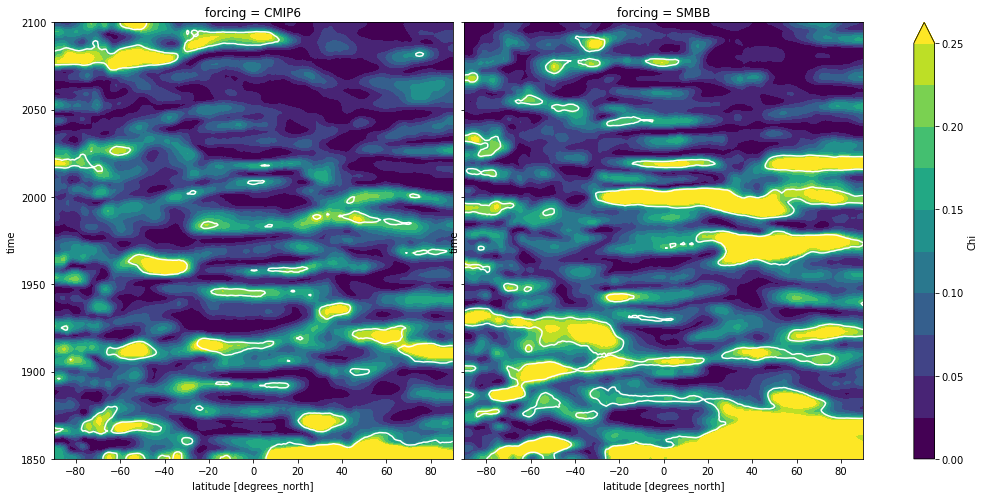

In [40]:
terms = xr.DataArray(['CMIP6','SMBB'],dims='forcing',name='forcing')
chi = xr.concat([chi_ocn_bb,chi_ocn_smbb],dim=terms)
pval = xr.concat([pval_bb,pval_smbb],dim=terms)

clevs = np.arange(0,11)*0.025
g = chi.plot.contourf(col='forcing',col_wrap=2,size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(forcing=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])